**First 20 Models Simultaneous Run**

General Imports

In [51]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.utils import all_estimators
import warnings
warnings.filterwarnings('ignore')

Automatically Importing All Regressions

In [52]:
estimators = all_estimators(type_filter='regressor')

all_regs = []
for name, RegressorClass in estimators:
    try:
        if name != 'DummyRegressor' and name != 'GaussianProcessRegressor' and name != 'QuantileRegressor' and name != 'SGDRegressor':
            print('Appending', name)
            reg = RegressorClass()
            all_regs.append(reg)
    except Exception as e:
        print(e)

print(all_regs)

Appending ARDRegression
Appending AdaBoostRegressor
Appending BaggingRegressor
Appending BayesianRidge
Appending CCA
Appending DecisionTreeRegressor
Appending ElasticNet
Appending ElasticNetCV
Appending ExtraTreeRegressor
Appending ExtraTreesRegressor
Appending GammaRegressor
Appending GradientBoostingRegressor
Appending HistGradientBoostingRegressor
Appending HuberRegressor
Appending IsotonicRegression
Appending KNeighborsRegressor
Appending KernelRidge
Appending Lars
Appending LarsCV
Appending Lasso
Appending LassoCV
Appending LassoLars
Appending LassoLarsCV
Appending LassoLarsIC
Appending LinearRegression
Appending LinearSVR
Appending MLPRegressor
Appending MultiOutputRegressor
__init__() missing 1 required positional argument: 'estimator'
Appending MultiTaskElasticNet
Appending MultiTaskElasticNetCV
Appending MultiTaskLasso
Appending MultiTaskLassoCV
Appending NuSVR
Appending OrthogonalMatchingPursuit
Appending OrthogonalMatchingPursuitCV
Appending PLSCanonical
Appending PLSRegress

Load and Describe Data

In [53]:
def load_pp_data():
    csv_path = os.path.abspath("Folds5x2_pp.csv")
    return pd.read_csv(csv_path)

pp = load_pp_data()
print(pp.describe())

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000


Train/Test Split and Preprocess Data

In [54]:
pp["AT_cat"] = pd.cut(pp["AT"],bins=[0.,10.,20.,30.,np.inf],labels=[1,2,3,4])

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(pp,pp["AT_cat"]):
    train_set = pp.loc[train_index]
    test_set = pp.loc[test_index]

for set_ in(train_set,test_set):
    set_.drop("AT_cat",axis=1,inplace=True)

pptrain = train_set.copy()
pptest = test_set.copy()

pptrain_attrib = pptrain.drop("PE",axis=1)
pptrain_labels = pptrain["PE"].copy()
pptest_attrib = pptest.drop("PE",axis=1)
pptest_labels = pptest["PE"].copy()

scaler = StandardScaler()
scaler.fit_transform(pptrain_attrib)

array([[ 1.1978498 ,  0.96554795,  0.37377565, -2.67409022],
       [ 0.64009018, -1.03750958, -1.88469509, -2.35340963],
       [-1.82211612, -1.45609422, -0.36887464,  1.17611946],
       ...,
       [-1.07754063, -0.84989538,  0.57724148,  0.20454577],
       [-0.67971691, -0.96104497,  0.78748951,  0.87314098],
       [ 0.89545   ,  0.56351752, -0.13658448, -1.12107019]])

Simultaneous Run

checking ARDRegression()
checking AdaBoostRegressor()
checking BaggingRegressor()
checking BayesianRidge()
checking CCA()


,rmse,r2,mae
BaggingRegressor(),3.5612,0.9571,2.4347
BayesianRidge(),4.4870,0.9319,3.5608
ARDRegression(),4.4875,0.9319,3.5606
AdaBoostRegressor(),5.1105,0.9116,4.0430


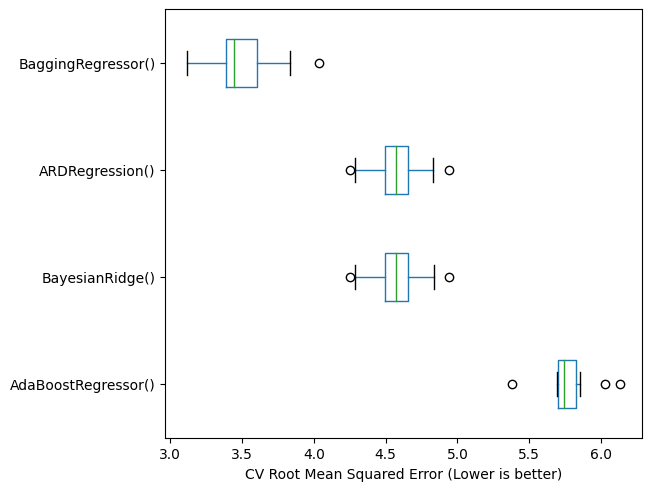

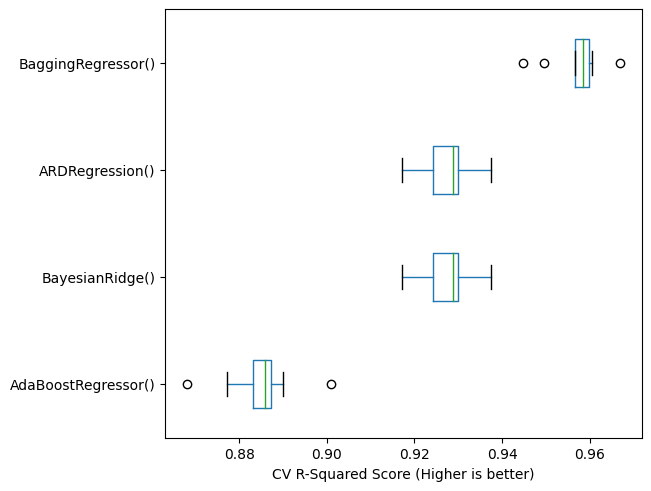

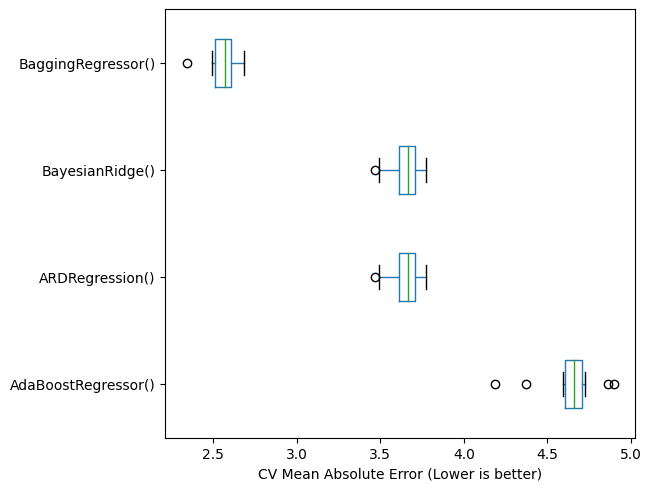

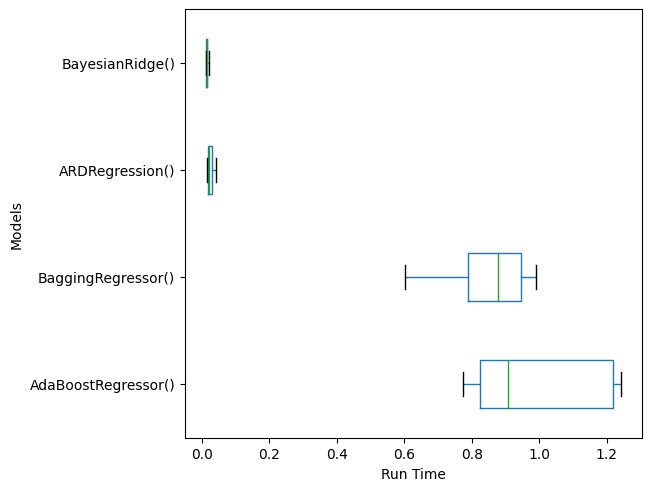

In [55]:
def comparison(modellst):
    cv_data = []
    errors = []
    passed_models = []
    for i in range(len(modellst)):
        x = run(modellst[i])
        if type(x) == dict:
            cv_data += [x]
        else:
            errors += [i]
    for j in range(len(modellst)):
        if j not in errors:
            passed_models += [modellst[j]]
    box_rmse(cv_data, passed_models), box_r2(cv_data, passed_models), box_mae(cv_data, passed_models), runtime(cv_data, passed_models)
    pdf = PdfPages('boxplots.pdf')
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs:
        fig.savefig(pdf, format='pdf')
    pdf.close
    return test_best(cv_data, passed_models)


def run(model):
    print(f"checking {model}")
    try:
        cv_outer = KFold(n_splits=10, shuffle=True, random_state=2)
        cv_output_dict = cross_validate(model, pptrain_attrib, pptrain_labels, scoring=["neg_mean_squared_error","neg_mean_absolute_error","r2"], cv=cv_outer, return_estimator=True)
        return cv_output_dict
    except:
        pass


def runtime(cv_data, passed_models):
    timefig = plt.figure(constrained_layout=True)
    df = pd.DataFrame()
    for i,j in zip(cv_data,passed_models):
        df[j] = list(i[('fit_time')])
    sorted_index = df.median().sort_values().index
    df_sorted=df[sorted_index]
    top20 = df_sorted.drop(columns=df_sorted.columns[20:])
    top20_sorted_index = top20.median().sort_values(ascending=False).index
    top20_sorted=top20[top20_sorted_index]
    top20_sorted.boxplot(vert=False,grid=False)
    plt.xlabel('Run Time')
    plt.ylabel('Models')
    return timefig


def box_rmse(cv_data, passed_models):
    RMSEfig = plt.figure(constrained_layout=True)
    df = pd.DataFrame()
    for i,j in zip(cv_data,passed_models):
        df[j] = list(np.sqrt(i['test_neg_mean_squared_error']*-1))
    sorted_index = df.median().sort_values().index
    df_sorted=df[sorted_index]
    top20 = df_sorted.drop(columns=df_sorted.columns[20:])
    top20_sorted_index = top20.median().sort_values(ascending=False).index
    top20_sorted=top20[top20_sorted_index]
    top20_sorted.boxplot(vert=False,grid=False)
    plt.xlabel(f'CV Root Mean Squared Error (Lower is better)')
    return RMSEfig


def box_r2(cv_data, passed_models):
    R2fig = plt.figure(constrained_layout=True)
    df = pd.DataFrame()
    for i,j in zip(cv_data,passed_models):
        df[j] = list(i['test_r2'])
    sorted_index = df.median().sort_values(ascending=False).index
    df_sorted=df[sorted_index]
    top20 = df_sorted.drop(columns=df_sorted.columns[20:])
    top20_sorted_index = top20.median().sort_values().index
    top20_sorted=top20[top20_sorted_index]
    top20_sorted.boxplot(vert=False,grid=False)
    plt.xlabel(f'CV R-Squared Score (Higher is better)')
    return R2fig


def box_mae(cv_data, passed_models):
    MAEfig = plt.figure(constrained_layout=True)
    df = pd.DataFrame()
    for i,j in zip(cv_data,passed_models):
        df[j] = list(i['test_neg_mean_absolute_error']*-1)
    sorted_index = df.median().sort_values().index
    df_sorted=df[sorted_index]
    top20 = df_sorted.drop(columns=df_sorted.columns[20:])
    top20_sorted_index = top20.median().sort_values(ascending=False).index
    top20_sorted=top20[top20_sorted_index]
    top20_sorted.boxplot(vert=False,grid=False)
    plt.xlabel(f'CV Mean Absolute Error (Lower is better)')
    return MAEfig


def test_best(cv_data, passed_models):
    rmse = []
    r2 = []
    mae = []
    for i in cv_data:
        x = list((np.sqrt(i['test_neg_mean_squared_error']*-1)))
        y = list(i['estimator'])
        for j in range(len(x)):
            if x[j] == min(x):
                best = y[j]
        predictions = best.predict(pptest_attrib)
        rmse += [np.sqrt(mean_squared_error(pptest_labels,predictions))]
        r2 += [r2_score(pptest_labels,predictions)]
        mae += [mean_absolute_error(pptest_labels,predictions)]
    columnnames = ['rmse','r2','mae']
    df = pd.DataFrame(np.array([rmse,r2,mae]).T,index=passed_models,columns=columnnames)
    sorted_df = df.sort_values(by="rmse",ascending=True)
    final_df = sorted_df.style.format("{:.4f}")
    return final_df


y = all_regs
x = all_regs[0:5]
comparison(x)